<a href="https://colab.research.google.com/github/shubhamsks/deep-learning/blob/master/object_recognition_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

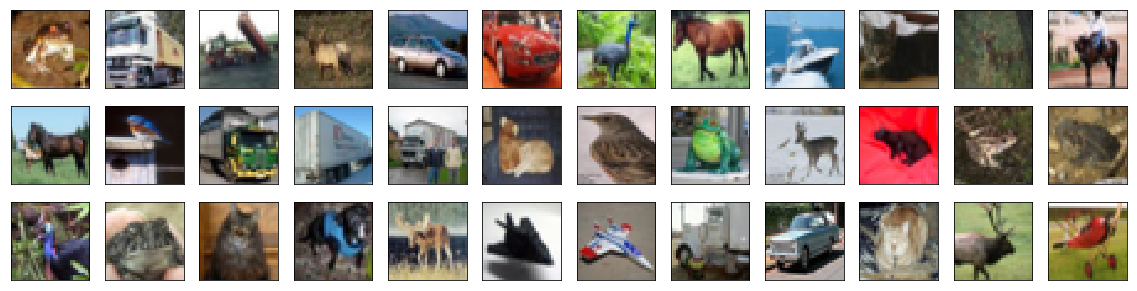

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [0]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

In [4]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


In [0]:
# Create and configure augmented image generator
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  horizontal_flip = True)
datagen_train.fit(x_train)

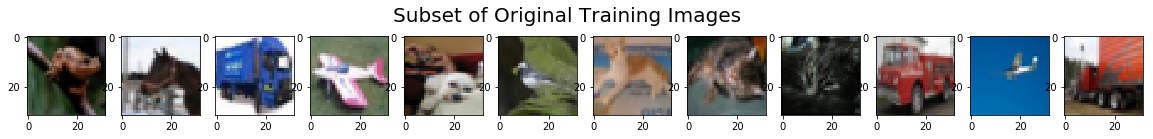

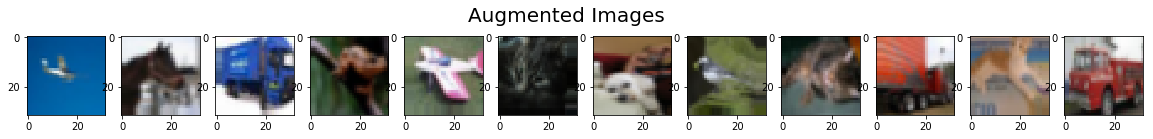

In [7]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)          0         
__________

In [10]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

W0816 12:38:19.072347 139763216791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 12:38:19.097022 139763216791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [15]:
from keras.callbacks import ModelCheckpoint   

batch_size = 2000
epochs = 39

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/39
 - 14s - loss: 0.6479 - acc: 0.7722 - val_loss: 0.5861 - val_acc: 0.8010

Epoch 00001: val_loss improved from inf to 0.58610, saving model to aug_model.weights.best.hdf5
Epoch 2/39
 - 13s - loss: 0.6459 - acc: 0.7708 - val_loss: 0.5816 - val_acc: 0.7994

Epoch 00002: val_loss improved from 0.58610 to 0.58158, saving model to aug_model.weights.best.hdf5
Epoch 3/39
 - 13s - loss: 0.6458 - acc: 0.7715 - val_loss: 0.5824 - val_acc: 0.8024

Epoch 00003: val_loss did not improve from 0.58158
Epoch 4/39
 - 13s - loss: 0.6480 - acc: 0.7724 - val_loss: 0.5778 - val_acc: 0.8036

Epoch 00004: val_loss improved from 0.58158 to 0.57777, saving model to aug_model.weights.best.hdf5
Epoch 5/39
 - 13s - loss: 0.6477 - acc: 0.7716 - val_loss: 0.5793 - val_acc: 0.8036

Epoch 00005: val_loss did not improve from 0.57777
Epoch 6/39
 - 13s - loss: 0.6517 - acc: 0.7703 - val_loss: 0.5804 - val_acc: 0.8048

Epoch 00006: val_loss did not improve from 0.57777
Epoch 7/39
 - 13s - loss: 0.6438 - acc: 0

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

In [17]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7941


In [0]:
y_hat = model.predict(x_test)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

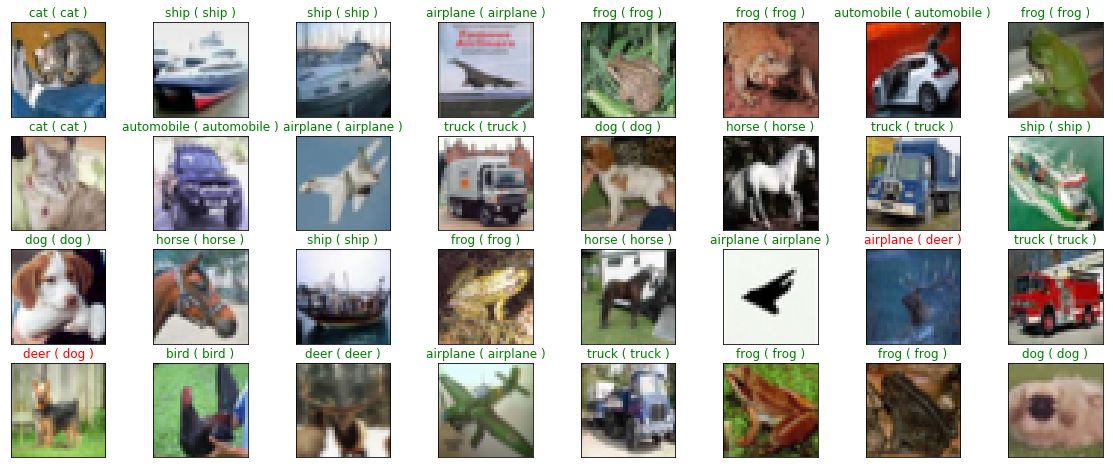

In [23]:
fig = plt.figure(figsize = (20,8))
for i in range(32):
  ax = fig.add_subplot(4, 8, i + 1, xticks =[], yticks = [])
  ax.imshow(x_test[i])
  pred_idx = np.argmax(y_hat[i])
  true_idx = np.argmax(y_test[i])
  ax.set_title("{} ( {} )".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
               color = 'green' if pred_idx == true_idx else 'red')